# Zillow Regression Project 

In [34]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pydataset import data

import wrangle as w
import explore as ex
import evaluate as ev

from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# set and use zillow color palette
zpalette = ['#1277e1', '#f3ad35', '#0b449c', '#5289e4', '#c3eafb']
sns.set_palette(zpalette)
sns.color_palette()

[(0.07058823529411765, 0.4666666666666667, 0.8823529411764706),
 (0.9529411764705882, 0.6784313725490196, 0.20784313725490197),
 (0.043137254901960784, 0.26666666666666666, 0.611764705882353),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.7647058823529411, 0.9176470588235294, 0.984313725490196)]

In [3]:
# set continous palette 
z_contpalette = ['#c3eafb', '#74acfc', '#5289e4', '#448cfc', '#126cfa']

# I think you can also do a colormap between two colors as well

In [4]:
sns.color_palette(z_contpalette)

[(0.7647058823529411, 0.9176470588235294, 0.984313725490196),
 (0.4549019607843137, 0.6745098039215687, 0.9882352941176471),
 (0.3215686274509804, 0.5372549019607843, 0.8941176470588236),
 (0.26666666666666666, 0.5490196078431373, 0.9882352941176471),
 (0.07058823529411765, 0.4235294117647059, 0.9803921568627451)]

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Acquire / Prepare
#### Goals
- get data 
- look at and deal with nulls and duplicates
- understand what I'm looking at

In [5]:
# get data using sql query and wrangle function

df = w.get_zillow_data()

In [6]:
# take a peak at data
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
0,11721753,205123.0,2.0,3.0,1316.0,6037.0,2627.48,2017-07-21
1,11289917,136104.0,2.0,3.0,1458.0,6037.0,2319.90,2017-06-23
2,11705026,35606.0,1.0,2.0,1421.0,6037.0,543.69,2017-06-30
3,14269464,880456.0,3.0,4.0,2541.0,6059.0,9819.72,2017-06-01
4,11446756,107110.0,2.0,3.0,1491.0,6037.0,1399.27,2017-08-23


In [7]:
# look at column info see if there's anything need to change as far as types
# can see some nulls
# need to change date to a datetime object 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28124 entries, 0 to 28123
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         28124 non-null  int64  
 1   tax_value         28123 non-null  float64
 2   bathroom_cnt      28124 non-null  float64
 3   bedroom_cnt       28124 non-null  float64
 4   sqft_calculated   28077 non-null  float64
 5   fips              28124 non-null  float64
 6   tax_amount        28123 non-null  float64
 7   transaction_date  28124 non-null  object 
dtypes: float64(6), int64(1), object(1)
memory usage: 1.9+ MB


In [42]:
# change transaction_date to datetime object
# line is in wrangle.py
df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [43]:
df.transaction_date.dtypes

dtype('<M8[ns]')

In [8]:
df.duplicated().value_counts()

False    28124
dtype: int64

In [9]:
w.missing_values_table(df)

Your selected dataframe has 8 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
sqft_calculated,47,0.2
tax_value,1,0.0
tax_amount,1,0.0


#### Takeaways Nulls / Dupes
- There are no duplicates! 
- Not too many missing values. Will probably drop them. But will take a look at the columns individually
- 47 sqft missing - DROP
- 1 tax_value - DROP
- 1 tax_amount DROP (thought about keeping it just for modeling and throwing it out for county tax info but it's just 1 row)

In [10]:
# look at rows that have NaNs
df[df.isna().any(axis=1)]

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
54,14430658,5346951.0,0.0,0.0,NaN,6059.0,82484.04,2017-08-25
325,14466991,2493444.0,0.0,0.0,NaN,6059.0,25740.28,2017-05-01
968,13972530,270009.0,0.0,0.0,NaN,6059.0,3230.88,2017-05-04
969,14325627,7074075.0,0.0,0.0,NaN,6059.0,81640.56,2017-05-04
988,12686981,5461875.0,0.0,0.0,NaN,6037.0,60905.26,2017-05-04
2679,12131538,225126.0,0.0,0.0,NaN,6037.0,2736.14,2017-05-11
4148,17292027,3210155.0,0.0,0.0,NaN,6111.0,34159.22,2017-05-18
5232,12920381,352000.0,2.0,3.0,944.0,6037.0,NaN,2017-05-24
5605,14430787,5126781.0,0.0,0.0,NaN,6059.0,80251.50,2017-05-25
6637,17267536,26237.0,0.0,0.0,NaN,6111.0,302.94,2017-05-30


In [11]:
total_rows = df.shape[0] 
rows_with_nans =  df[df.isna().any(axis=1)].shape[0]

print(f'There are {total_rows} total rows, {rows_with_nans} of which have NaN values.')
print(f'If we drop the rows with NaNs there should be {total_rows-rows_with_nans} rows left')
print(f'It\'s {rows_with_nans/total_rows:.2%} of the data')

There are 28124 total rows, 49 of which have NaN values.
If we drop the rows with NaNs there should be 28075 rows left
It's 0.17% of the data


In [12]:
# Check to make sure numbers match up
df.drop(df[df.isna().any(axis=1)].index).shape

(28075, 8)

In [13]:
#drop the rows 
df.drop(df[df.isna().any(axis=1)].index, inplace=True)

In [14]:
# check to make sure it worked
df.shape

(28075, 8)

In [15]:
# look at unique values in each column
for col in df.drop(columns=['parcel_id', 'tax_value', 'tax_amount']).columns:
    print(f'---------------')
    print(f'There are {df[col].nunique()} unique values in the {col} column')

---------------
There are 20 unique values in the bathroom_cnt column
---------------
There are 13 unique values in the bedroom_cnt column
---------------
There are 4055 unique values in the sqft_calculated column
---------------
There are 3 unique values in the fips column
---------------
There are 119 unique values in the transaction_date column


In [16]:
# single family homes are sometimes defined as houses that don't have more than 5 bedrooms
# filter to see how many we have above that
(df['bedroom_cnt']  > 5).value_counts()

False    27668
True       407
Name: bedroom_cnt, dtype: int64

In [17]:
df.bedroom_cnt.value_counts()

3.0     12551
4.0      8287
2.0      4348
5.0      2141
6.0       340
1.0       311
7.0        50
0.0        30
8.0         7
9.0         4
12.0        3
10.0        2
11.0        1
Name: bedroom_cnt, dtype: int64

#### Homes with more than 5 bedrooms
- there are 407 homes with MORE than 5 bedrooms
- won't get rid of them now but might be a good place to get rid of outliers

Also saw here there are columns with 0 bed rooms need to get rid of those

In [18]:
df[df.bedroom_cnt == 0].head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,fips,tax_amount,transaction_date
8,11696784,168828.0,0.0,0.0,1378.0,6037.0,2135.39,2017-06-16
231,11787436,188000.0,1.0,0.0,740.0,6037.0,2399.69,2017-05-01
253,11392193,101792.0,0.0,0.0,2276.0,6037.0,1609.95,2017-05-01
338,11266326,49627.0,0.0,0.0,400.0,6037.0,703.30,2017-05-01
793,11938527,319396.0,0.0,0.0,389.0,6037.0,4059.62,2017-05-03


#### 1 bathroom and 0 bedrooms with sqftage might be a studio! I will keep those in

#### 0 Bathroom and 0 (or any number of) bedrooms with sqftage will be dropped. can't guess how many beds and bathrooms those have

In [19]:
total_rows = df.shape[0] 
rows_with =  df[df.bathroom_cnt == 0].shape[0]

print(f'There are {total_rows} total rows, {rows_with} with 0 in the bathroom_cnt column.')
print(f'If we drop these rows there should be {total_rows-rows_with} rows left')
print(f'It\'s {rows_with_nans/total_rows:.2%} of the data')

There are 28075 total rows, 23 with 0 in the bathroom_cnt column.
If we drop these rows there should be 28052 rows left
It's 0.17% of the data


In [20]:
# drop the rows with the 0 bathroom count
df.drop(df[df.bathroom_cnt == 0].index, inplace=True)

In [21]:
df.shape

(28052, 8)

### Target
- tax_value

### Variables 
#### Categorial variables:
- fips
- bedrooms
- bathrooms 

#### Continous variables:
- sqft_calculated
- transaction_date 

#### Other
- parcel_id - unique identifer
- tax_amount - not used for modeling


In [22]:
# final test with wrangle.py function

df = w.wrangle_zillow()

In [23]:
# it worked, it has the correct shape

df.shape

(28052, 8)

<hr style="border-top: 10px groove #1277e1; margin-top: 1px; margin-bottom: 1px"></hr>

## Explore 
#### Goals 
- Univariate exploration 
    - find and deal with outliers
- train, validate, test split
- Multivariate exploration
- Vizualize relationship between variables and target
- Find Drivers
- State Hypotheses and run some Statistical Tests


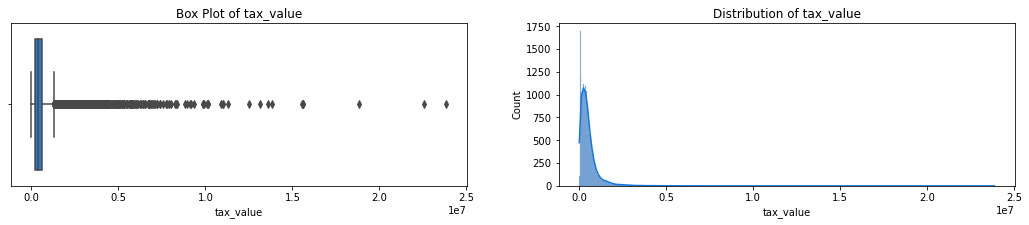

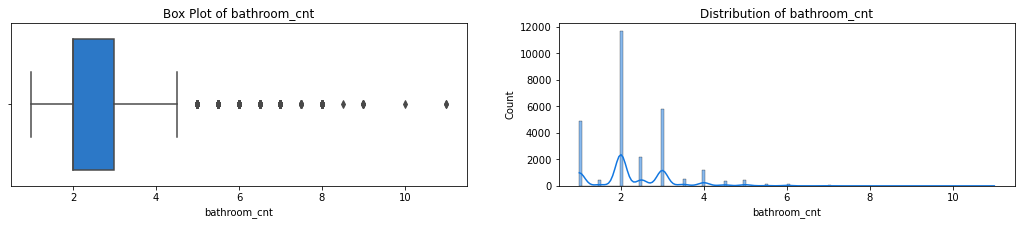

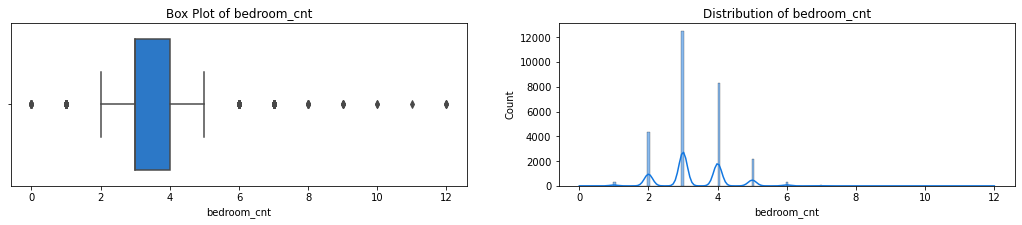

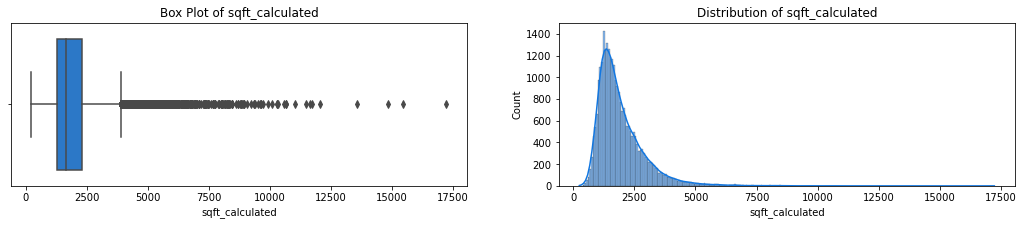

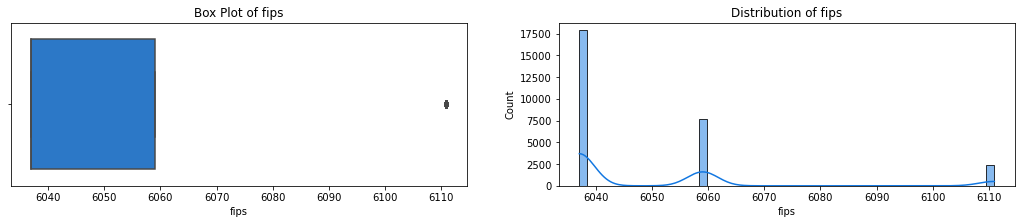

In [79]:
# use function from explore to look at distributions
ex.explore_univariate(df.drop(columns=['parcel_id', 'transaction_date', 'tax_amount']))

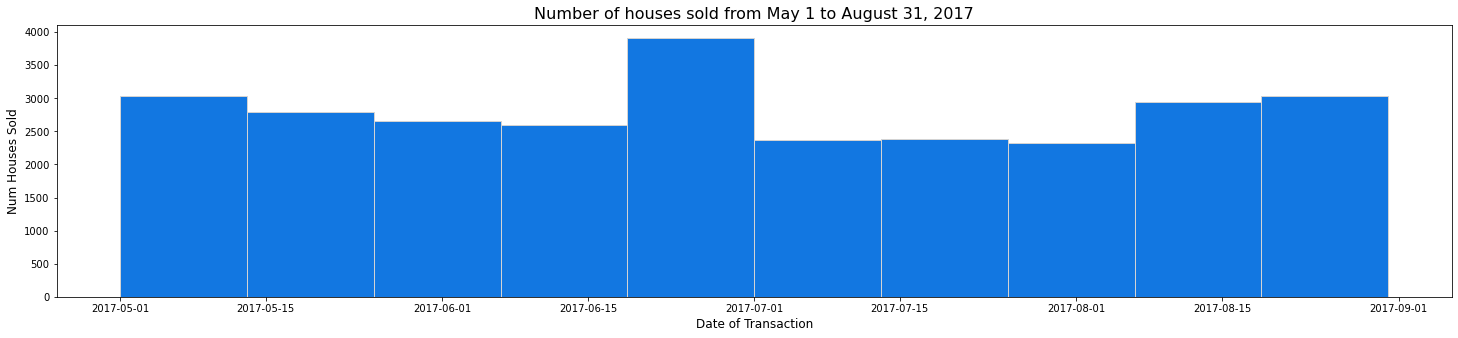

In [65]:
# plot dates houses were sold
plt.figure(figsize=(25, 5))
plt.hist(df.transaction_date, lw = 1, ec = 'lightgrey')
plt.xlabel('Date of Transaction', fontsize = 12)
plt.ylabel('Num Houses Sold', fontsize = 12)
plt.title('Number of houses sold from May 1 to August 31, 2017', fontsize = 16)
plt.show()

### Takeaways
- Need to drop outliers
- most of the houses are in LA county (fips 6037)
- The second half of June 2017 saw higher number of house sales

In [66]:
import scipy.stats as stats

def remove_outlier(df):
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df

In [71]:
df_new = remove_outlier(df[['sqft_calculated', 'bedroom_cnt', 'bathroom_cnt']])

In [90]:
df.shape[0] - df_new.shape[0]
print(f'{df.shape[0] - df_new.shape[0]} rows dropped')

641 rows dropped


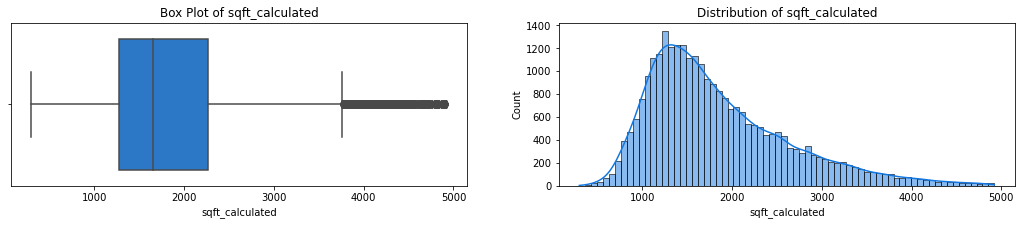

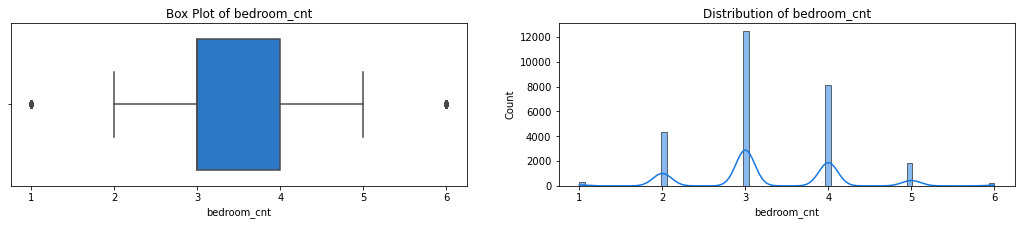

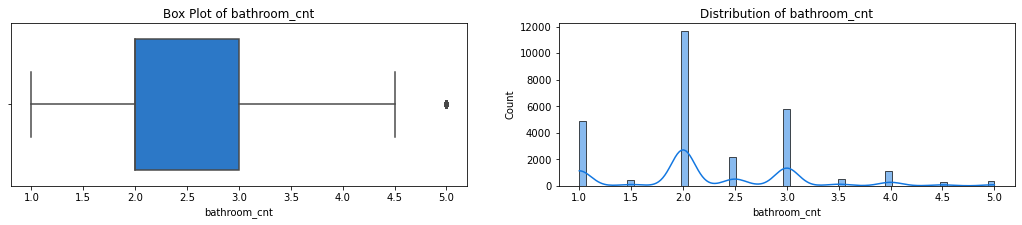

In [76]:
ex.explore_univariate(df_new)

### Takeaways
- After dropping outliers still a lot of outliers to deal with in sqft_calculated. will come back and deal with them later
- Makes sense though. Lots of really expensive houses in LA, Orange County, and Ventura County
- Maybe deal with outliers by scaling the data (using a non-linear scaler)
- is it ok to use a non-linear scaler with the linear regression
